## 决策树与K近邻分类

##### 分别使用 决策树 和 最近邻方法在分类任务上构建模型， 并通过交叉验证对模型进行调优
- 决策树
- 最近邻方法
- 交叉验证

> 机器学习定义： 假设用 P 来评估计算机程序在某任务类 T 上的性能，若一个程序利用经验 E 在任务 T 上获得了性能改善，则我们就说关于 T 和 P, 该程序对 E 进行了学习。

> 经验 E 指的是数据（没有数据我们什么也干不了）。
>> 根据训练方式，机器学习算法可以分为监督（supervised）和无监督（unsupervised）两类。
- 无监督学习需要训练含有很多特征的数据集，然后学习出这个数据集上有用的结构性质。
-  监督学习的数据集除了含有很多特征外，它的每个样本都要有一个标签（label）或目标（target）。

#### 在不同的问题设定下，T、P、E 可能指完全不同的东西。机器学习中一些流行的任务 T 包括：
- 分类：基于特征将实例分为某一类。
- 回归：基于实例的其他特征预测该实例的数值型目标特征。
- 聚类：基于实例的特征实现实例的分组，从而让组内成员比组间成员更为相似。
- 异常检测：寻找与其他样本或组内实例有很大区别的实例。
- 其他更多任务

### 分类和回归，属于监督学习
#### 例如：
- 信贷机构 希望根据用户累积的数据预测贷款违约情况
 - 此时E 就是已有的训练数据，即实例（客户）的集合， 一组特征（如：年龄、薪水、贷款类型、以往的违约记录） ； 一个目标（是否会违约） ； 
 - 由于需预测的目标变量是---是否会违约，此时就是一个二分类问题
 - 如果转而预测 贷款会超期多久，目标变量---一个超期的连续时间，此时就是一个回归问题

### 决策树

#### 分类问题中其他的分割质量标准

- 基尼不确定性（Gini uncertainty）：$G = 1 - \sum\limits_k (p_k)^2$
- 错分率（Misclassification error）：$E = 1 - \max\limits_k p_k$

##### 二元分类问题的熵和基尼不确定性为：
 
$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})}$$
$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+)$$

- 其中 $p_+$ 是对象具有标签 + 的概率。
- 以 $p_+$ 为坐标，绘制上面两个函数的图像。

In [3]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
warnings.filterwarnings('ignore')

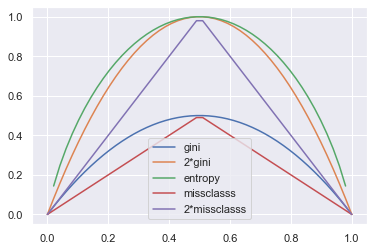

In [11]:
plt.figure(figsize=(6,4))
xx = np.linspace(0,1,50)
plt.plot(xx,[2 * x * (1-x) for x in xx] ,label='gini')
plt.plot(xx,[4 * x * (1-x) for x in xx] ,label='2*gini')
plt.plot(xx,[-x * np.log2(x) - (1-x)*np.log2(1-x)  for x in xx] ,label='entropy')
plt.plot(xx,[1-max(x,1-x) for x in xx] ,label='missclasss')
plt.plot(xx,[2-2* max(x,1-x) for x in xx] ,label='2*missclasss')
plt.legend()

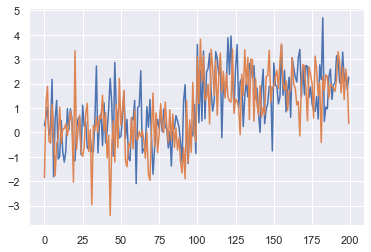

In [18]:
# 使用决策树拟合一些合成数据
## 第一类
np.random.seed(17)
train_data = np.random.normal(size=(100,2))
train_data
train_labels = np.zeros(100)
train_labels

## 第二类
train_data = np.r_[train_data, np.random.normal(size=(100,2), loc=2)]
train_labels = np.r_[train_labels,np.ones(100)]
train_labels
plt.plot(train_data)

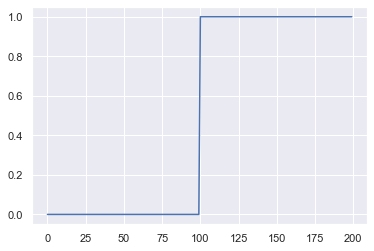

In [19]:
plt.plot(train_labels)

##### 为分类问题构造一个边界， 能较好的分开两个类别（红点、黄点）

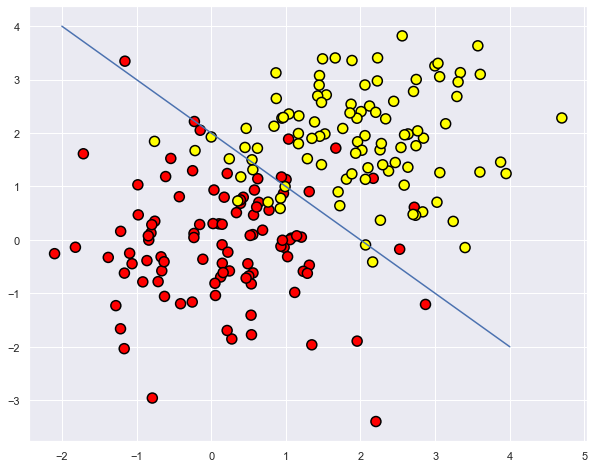

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(
    train_data[:,0], train_data[:,1], c= train_labels, s=100, cmap='autumn' , edgecolors='black' , linewidth=1.5
)
plt.plot(range(-2,5), range(4,-3,-1))